### Overview - Food101 Vision 🍕🍲
- We first started with 2 classes (pizza and steak) and built our own CNN models.
- Then we increased number of classes to 10 and built CNN but it performed poorly, so we leveraged transfer learning
- In transfer learning, we did feature extraction and fine tuning with 1%, 10% and 100% of the data for 10 classes. We did it with and without data augmentation. The top accuracy we achieved was ~88%. 

Now we'll use all 101 classes from Food101 dataset. Initially we'll train with 10% images for each class. Then we'll scale up


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

In [2]:
!nvidia-smi

Thu Aug 11 07:44:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2022-08-11 07:44:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-11 07:44:14 (65.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback
from helper_functions import unzip_data, walk_through_dir

In [6]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['categorical_accuracy']
  val_accuracy = history.history['val_categorical_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [7]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["categorical_accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_categorical_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["categorical_accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_categorical_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  

### Load and prepare the data for training

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data('101_food_classes_10_percent.zip')

--2022-08-11 07:44:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  68.8MB/s    in 25s     

2022-08-11 07:44:48 (61.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_

In [9]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

train_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                                        image_size = IMG_SIZE,
                                                                        label_mode = 'categorical')

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                        image_size = IMG_SIZE,
                                                        label_mode = 'categorical')

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Create ModelCheckPoint callback

In [ ]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         monitor = 'val_categorical_accuracy',
                                                         save_weight_only = True,
                                                         save_best_only = True)

In [ ]:
checkpoint_callback

### Create DataAugmentation layer

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomWidth(0.2),
        tf.keras.layers.RandomHeight(0.2),
        tf.keras.layers.RandomZoom(0.2)
        #tf.keras.layers.Rescaling(1./255.) # Not required for EfficientNet (But is required for ResNet)
    ], name = "data_augmentation_layer"
)
data_augmentation.layers

### Create head-less efficient net model architecture

In [ ]:
n_classes = len(train_data_all_10_percent.class_names)
class_names = train_data_all_10_percent.class_names

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape = IMG_SIZE + (3,), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool_2d')(x)
outputs = tf.keras.layers.Dense(n_classes, activation = 'softmax', name = "output_layer")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_2d (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                              

In [ ]:
### Compile and fit the model
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history1 = model.fit(
    train_data_all_10_percent,
    epochs = EPOCHS,
    validation_data = test_data,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_steps = int(0.15*len(test_data)), # Evaluate on 15% validation data during training to save time
    callbacks = [checkpoint_callback, 
                 create_tensorboard_callback("transfer_learning_food_101",
                                             "10_percent_data_functional_tl")]
)

Saving TensorBoard log files to: transfer_learning_food_101/10_percent_data_functional_tl/20220811-032149
Epoch 1/5
237/237 [==============================] - 141s 520ms/step - loss: 3.5155 - categorical_accuracy: 0.2331 - val_loss: 2.4945 - val_categorical_accuracy: 0.4372
Epoch 2/5
237/237 [==============================] - 96s 405ms/step - loss: 2.4234 - categorical_accuracy: 0.4403 - val_loss: 2.0560 - val_categorical_accuracy: 0.5013
Epoch 3/5
237/237 [==============================] - 90s 380ms/step - loss: 2.0597 - categorical_accuracy: 0.5114 - val_loss: 1.8797 - val_categorical_accuracy: 0.5283
Epoch 4/5
237/237 [==============================] - 87s 368ms/step - loss: 1.8405 - categorical_accuracy: 0.5556 - val_loss: 1.7860 - val_categorical_accuracy: 0.5458
Epoch 5/5
237/237 [==============================] - 97s 408ms/step - loss: 1.6962 - categorical_accuracy: 0.5830 - val_loss: 1.7425 - val_categorical_accuracy: 0.5493


In [ ]:
results1 = model.evaluate(test_data)

790/790 [==============================] - 74s 93ms/step - loss: 1.7281 - categorical_accuracy: 0.5498


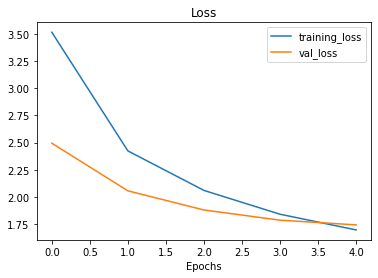

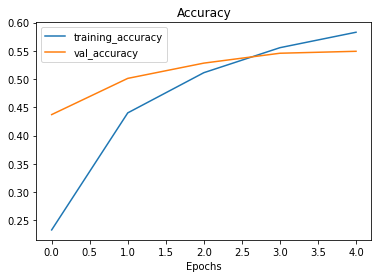

In [ ]:
plot_loss_curves(history1)

**Model 1 is little bit overfitting looking at the accuracy curve. We'll continue with Fine tuning**

### Unfreeze and fine tune last 5 layers

In [ ]:
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

## Load the model weights from saved ModelCheckpoint
model.load_weights('101_classes_10_percent_data_model_checkpoint')

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Decreasing learning rate
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_2d (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
len(model.trainable_variables)

8

In [ ]:
# Just check if the loaded model is same as the feature extraction model
model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.7281 - categorical_accuracy: 0.5498


[1.7280662059783936, 0.5498217940330505]

In [ ]:
## These results are same as before. So we have loaded the correct model

In [ ]:
initial_epochs = EPOCHS
fine_tune_epochs = initial_epochs + EPOCHS

history2 = model.fit(
    train_data_all_10_percent,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_steps = int(0.15*len(test_data)),
    initial_epoch = history1.epoch[-1],
    callbacks = [create_tensorboard_callback("transfer_learning_food_101",
                                             "10_percent_data_fine_tune_last_5")]
)

Saving TensorBoard log files to: transfer_learning_food_101/10_percent_data_fine_tune_last_5/20220811-034301
Epoch 5/10
237/237 [==============================] - 54s 198ms/step - loss: 1.6197 - categorical_accuracy: 0.6040 - val_loss: 1.6684 - val_categorical_accuracy: 0.5596
Epoch 6/10
237/237 [==============================] - 44s 183ms/step - loss: 1.4522 - categorical_accuracy: 0.6499 - val_loss: 1.6242 - val_categorical_accuracy: 0.5675
Epoch 7/10
237/237 [==============================] - 46s 192ms/step - loss: 1.3755 - categorical_accuracy: 0.6597 - val_loss: 1.5863 - val_categorical_accuracy: 0.5757
Epoch 8/10
237/237 [==============================] - 45s 189ms/step - loss: 1.3155 - categorical_accuracy: 0.6742 - val_loss: 1.5693 - val_categorical_accuracy: 0.5816
Epoch 9/10
237/237 [==============================] - 44s 182ms/step - loss: 1.2391 - categorical_accuracy: 0.6906 - val_loss: 1.5501 - val_categorical_accuracy: 0.5869
Epoch 10/10
237/237 [=========================

In [ ]:
results2 = model.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.5423 - categorical_accuracy: 0.5909


In [ ]:
print(f"Feature extraction model: Loss = {results1[0]}, Accuracy = {results1[1]}.")
print(f"Fine-Tuned model: Loss = {results2[0]}, Accuracy = {results2[1]}.")

Feature extraction model: Loss = 1.728065013885498, Accuracy = 0.5498217940330505.
Fine-Tuned model: Loss = 1.5423493385314941, Accuracy = 0.5908910632133484.


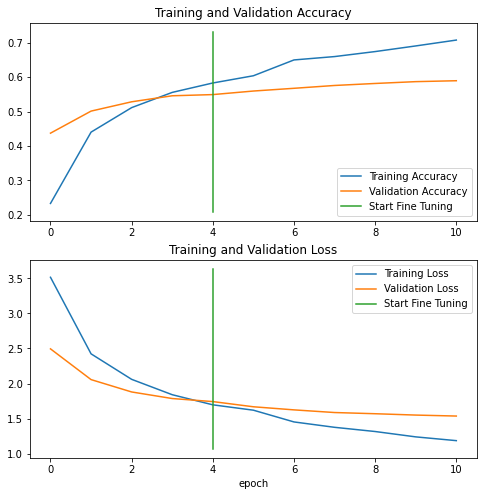

In [ ]:
compare_historys(history1, history2, initial_epochs=5)

**Model accuracy and loss have improved but looks like the model is still overfitting**

### Save and load the model

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/101_food_classes_10_percent_fine_tuned")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/101_food_classes_10_percent_fine_tuned")

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_2d (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 62s 75ms/step - loss: 1.5423 - categorical_accuracy: 0.5909


[1.5423495769500732, 0.5908910632133484]

### Lets make some predictions 

In [10]:
## Loading a pre-trained model, so that the results are same as the lectures
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

--2022-08-11 07:45:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  33.8MB/s    in 1.3s    

2022-08-11 07:45:24 (33.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [11]:
pre_trained_model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [12]:
pre_trained_model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

In [ ]:
pre_trained_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027225732803345, 0.6077623963356018]

In [ ]:
preds = pre_trained_model.predict(test_data, verbose=1)

790/790 [==============================] - 82s 82ms/step


In [ ]:
preds.shape

(25250, 101)

In [ ]:
preds[0], preds[0].shape, tf.reduce_max(preds[0]), preds[0].argmax()

(array([1.4640634e-08, 1.1821499e-05, 2.6285621e-10, 1.5228976e-10,
        2.4278600e-12, 2.7733909e-08, 5.6470273e-10, 3.9177682e-08,
        2.4397570e-05, 5.0463073e-10, 1.8259179e-12, 9.6168048e-14,
        2.3269167e-10, 5.1317887e-11, 1.1587876e-09, 1.1388020e-10,
        1.8598399e-05, 7.2052353e-07, 1.6923652e-05, 2.2274643e-10,
        4.8498748e-07, 4.7562406e-03, 3.4396544e-03, 4.7361413e-05,
        3.6783621e-07, 4.6651729e-15, 7.5723889e-09, 1.9948393e-05,
        1.9317592e-13, 7.1733606e-09, 1.7125727e-14, 1.4747881e-06,
        9.7714605e-05, 8.8758141e-12, 3.8280416e-12, 8.1120779e-06,
        4.8264219e-09, 2.7683396e-07, 1.2852066e-11, 6.3413964e-08,
        2.0995543e-09, 7.2690156e-05, 6.3225167e-09, 4.4875272e-09,
        1.1861198e-10, 1.8045501e-05, 7.0347042e-14, 1.3484936e-06,
        3.8764395e-12, 6.9190573e-09, 6.2585007e-11, 7.1245655e-11,
        6.7307628e-06, 3.1961161e-10, 9.9035174e-01, 1.5735451e-11,
        1.3333264e-09, 2.8792008e-10, 2.6157777e

In [ ]:
class_names = test_data.class_names
n_classes = len(test_data.class_names)

In [ ]:
class_names[preds[0].argmax()]

'hot_and_sour_soup'

In [ ]:
### All predicted classses
pred_classes = preds.argmax(axis=1)
pred_classes_str = [class_names[pred_class] for pred_class in pred_classes]
pred_classes[:10], pred_classes_str[:10]

(array([54, 61, 20,  9, 52, 92, 45, 94, 83, 81]),
 ['hot_and_sour_soup',
  'lobster_roll_sandwich',
  'chicken_wings',
  'breakfast_burrito',
  'gyoza',
  'spring_rolls',
  'frozen_yogurt',
  'strawberry_shortcake',
  'red_velvet_cake',
  'ramen'])

### Compare with actual classes - Unravel the test data

🔑**Here we are recreating the test data with shuffle=False, we that when we compare our prediction results and true lables, they are not shuffled and we can compare same things**

In [13]:
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                        image_size = IMG_SIZE,
                                                        label_mode = 'categorical',
                                                        shuffle = False)

Found 25250 files belonging to 101 classes.


In [14]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [15]:
class_names = test_data.class_names
n_classes = len(test_data.class_names)

In [16]:
preds = pre_trained_model.predict(test_data, verbose=1)

790/790 [==============================] - 73s 77ms/step


In [17]:
y_pred = preds.argmax(axis=1)
len(y_pred)

25250

In [18]:
y_true = []
for image, label in test_data.unbatch():
  y_true.append(label.numpy().argmax()) # Since the lables are in one-hot encoded format
len(y_true)

25250

In [19]:
# Now lets verify if the prediction we have made are in the same order as the data is.
# For this we'll use y_true, y_preds to get accuracy score from sklearn-accuracy_score()
# And see if this gives us same accuracy score 0.6

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true, y_pred)
acc_score

0.6077623762376237

**So this is exact same as we got from model.evaluate().**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

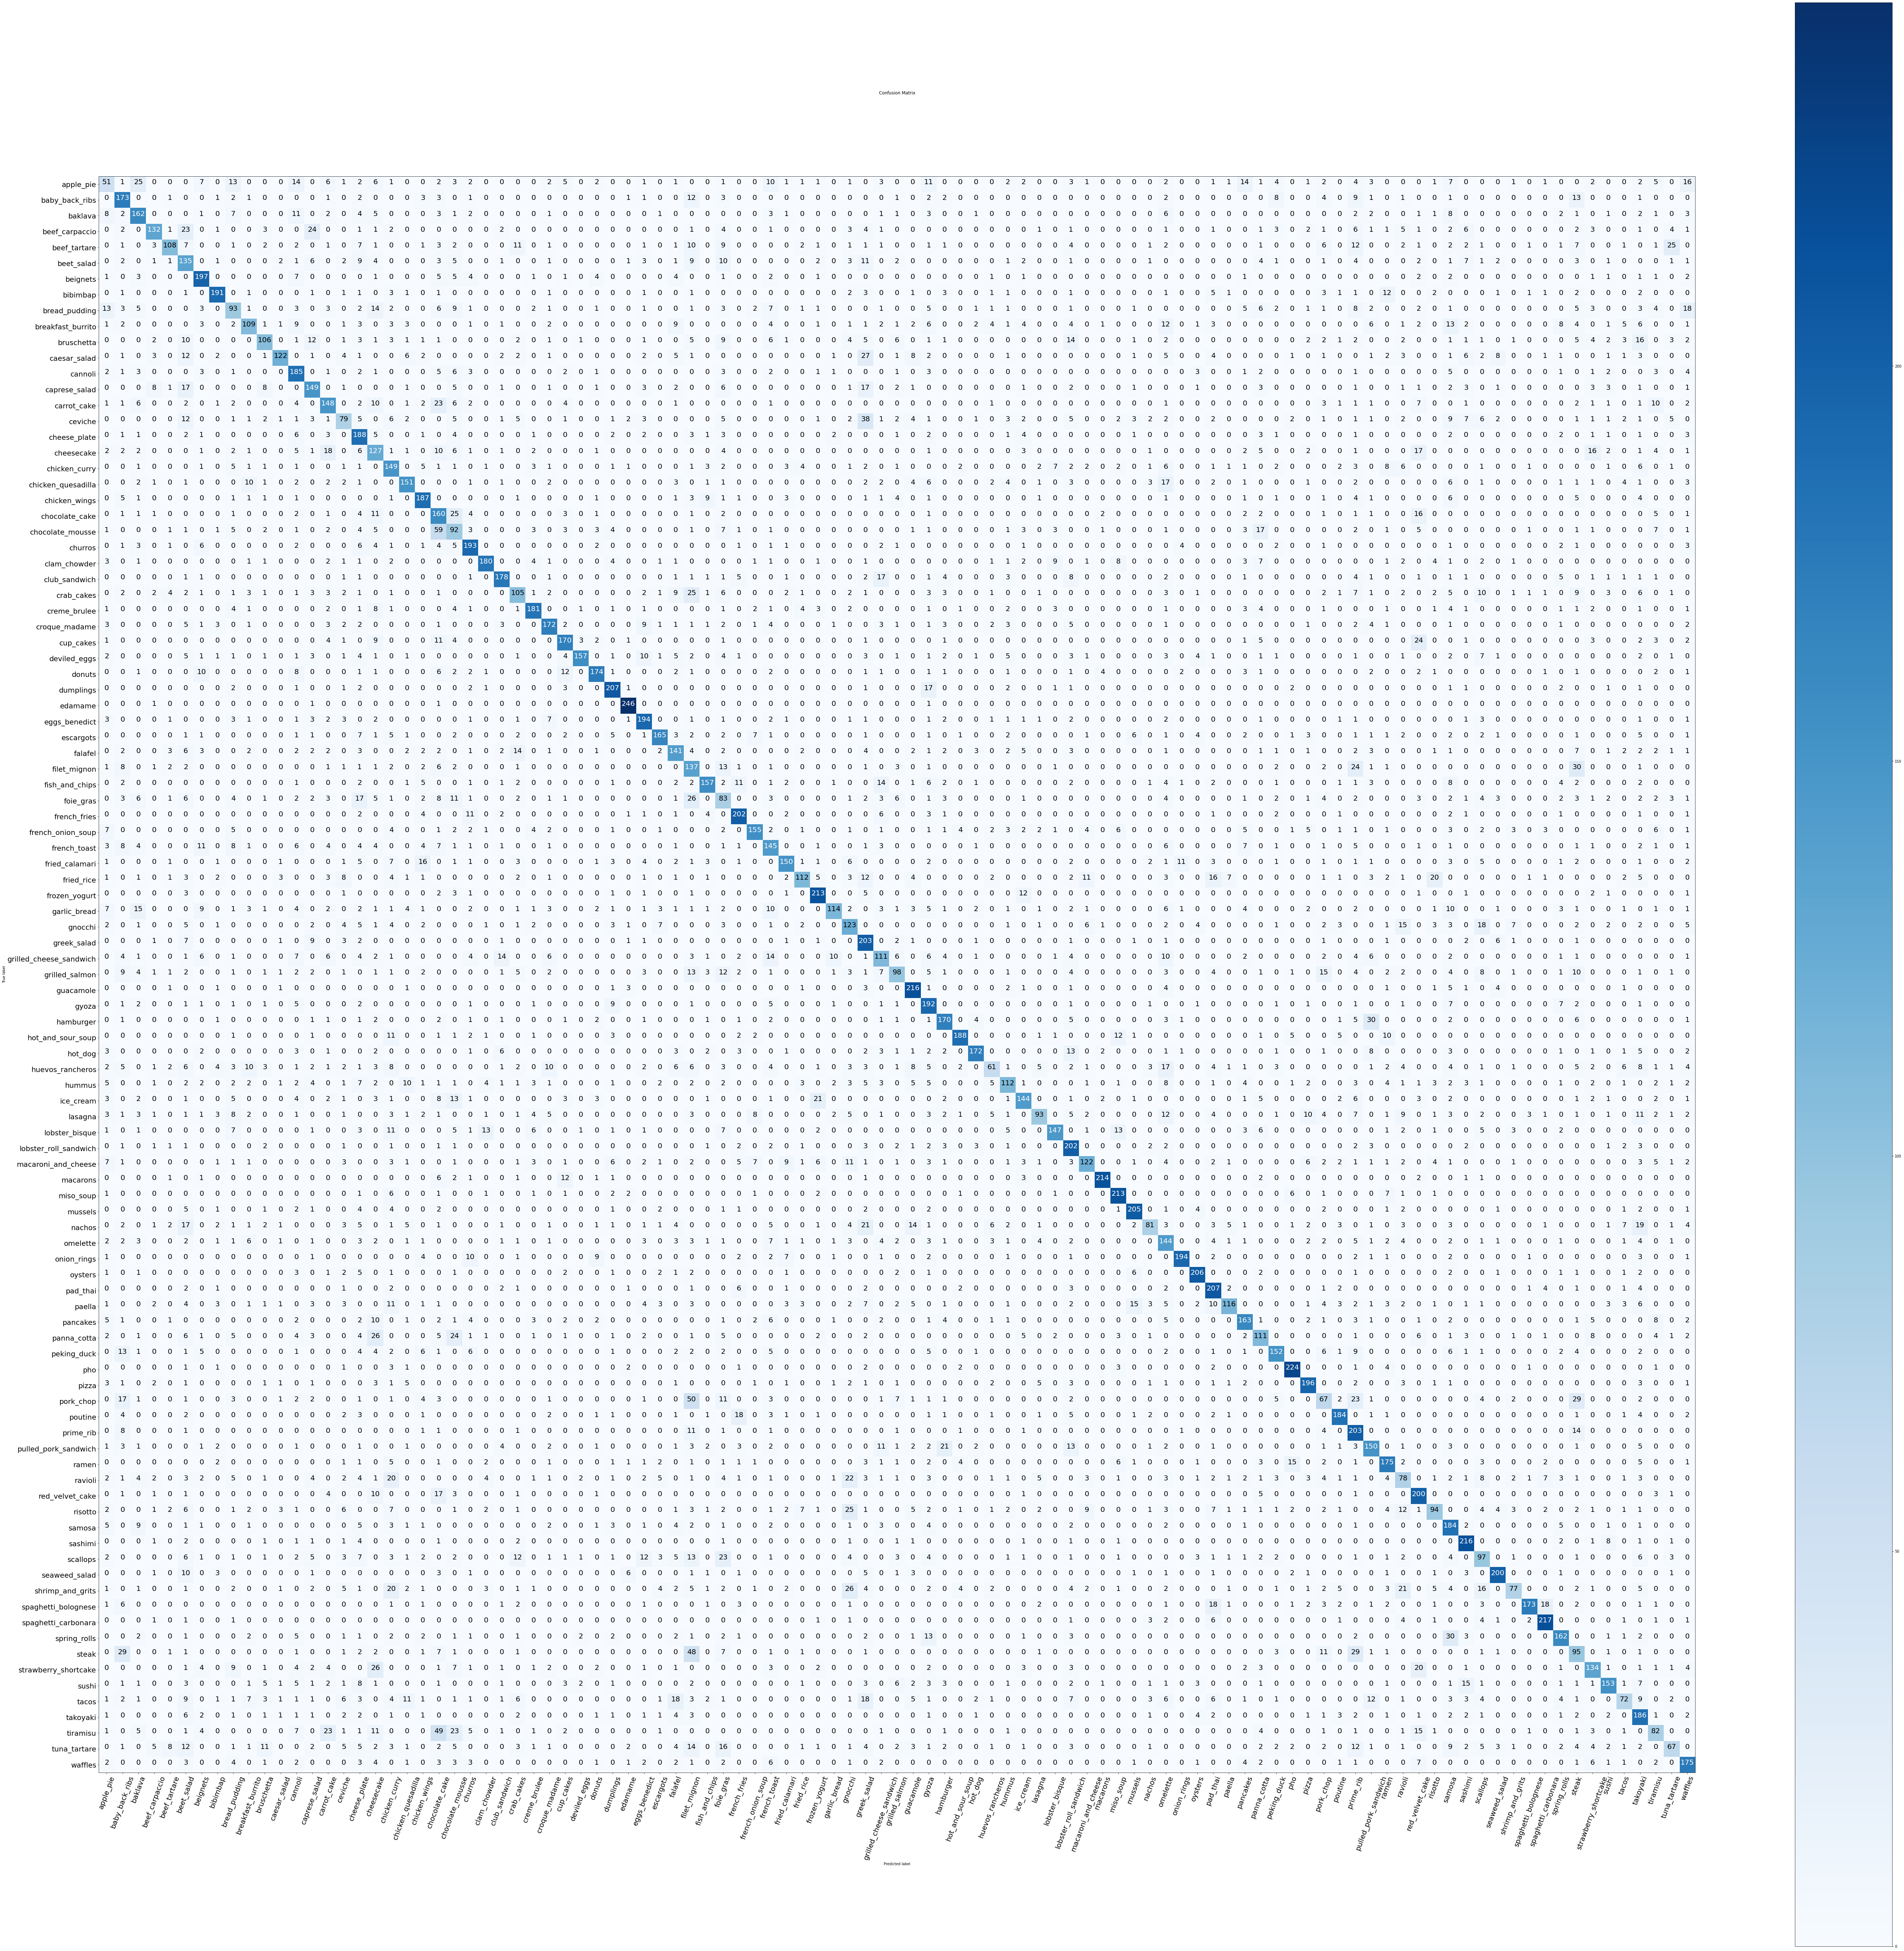

In [ ]:
make_confusion_matrix(y_true, 
                      y_pred, 
                      class_names,
                      figsize=(100, 100),
                      text_size=20)

### Sklearn classification report 

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names = class_names))

                         precision    recall  f1-score   support

              apple_pie       0.29      0.20      0.24       250
         baby_back_ribs       0.51      0.69      0.59       250
                baklava       0.56      0.65      0.60       250
         beef_carpaccio       0.74      0.53      0.62       250
           beef_tartare       0.73      0.43      0.54       250
             beet_salad       0.34      0.54      0.42       250
               beignets       0.67      0.79      0.72       250
               bibimbap       0.82      0.76      0.79       250
          bread_pudding       0.40      0.37      0.39       250
      breakfast_burrito       0.62      0.44      0.51       250
             bruschetta       0.62      0.42      0.50       250
           caesar_salad       0.84      0.49      0.62       250
                cannoli       0.52      0.74      0.61       250
          caprese_salad       0.56      0.60      0.58       250
            carrot_cake 

In [21]:
classification_report_dict = classification_report(y_true=y_true, 
                                                   y_pred=y_pred,
                                                   target_names = class_names,
                                                   output_dict=True)
type(classification_report_dict)

dict

In [22]:
f1_score_dict = {}
for k, v in classification_report_dict.items():
  if k not in ['weighted avg', 'macro avg', 'accuracy']:
    f1_score_dict[k] = v['f1-score']
len(f1_score_dict)

101

In [23]:
import pandas as pd
f1_score_df = pd.DataFrame({'class_name': f1_score_dict.keys(), 'f1_score': f1_score_dict.values()})
f1_score_df.head()

class_name  f1_score
0       apple_pie  0.240566
1  baby_back_ribs  0.586441
2         baklava  0.602230
3  beef_carpaccio  0.616822
4    beef_tartare  0.544081

In [24]:
f1_score_df = f1_score_df.sort_values("f1_score", ascending=False)
f1_score_df.head(10)

class_name  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

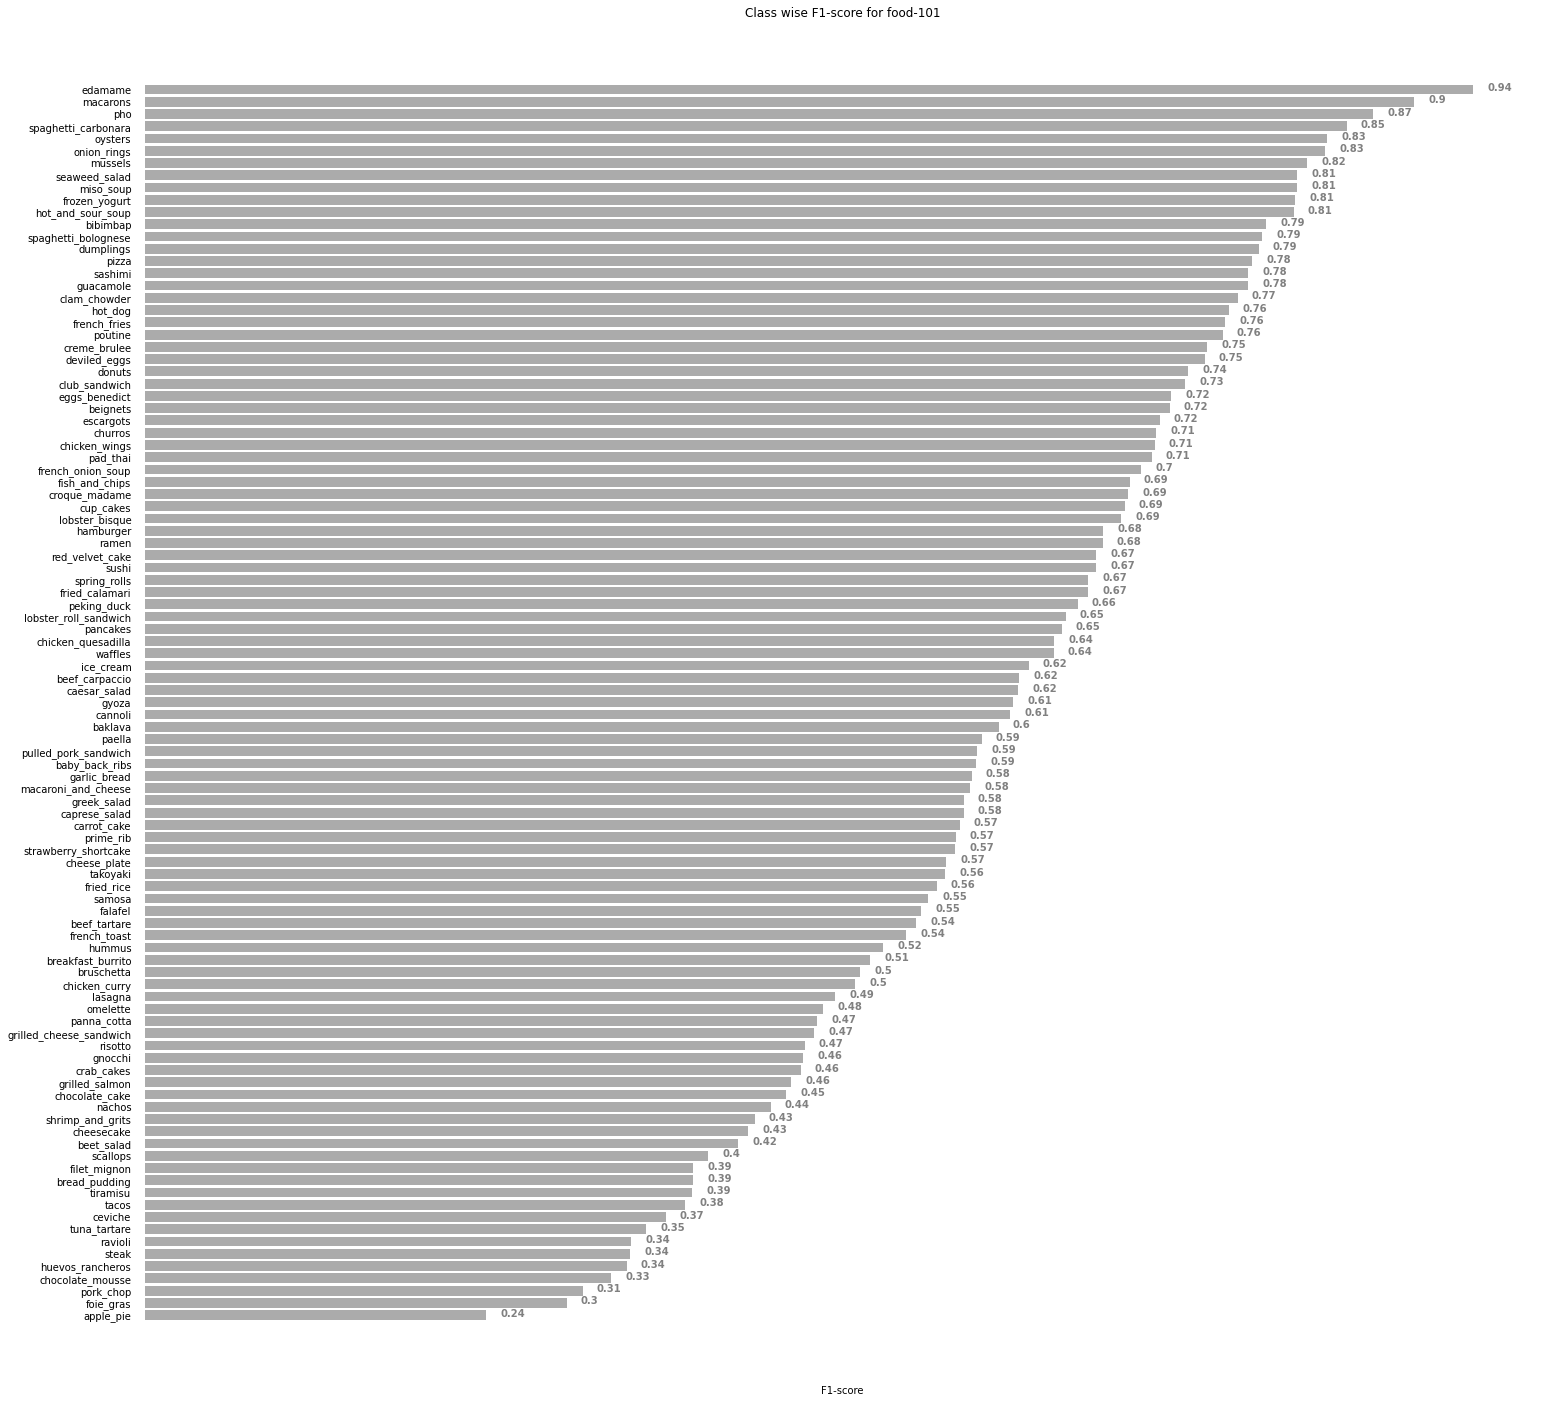

In [25]:
# Color Blind 10 colors with RGB values
cb_dark_blue = (0/255.0, 107/255.0, 164/255.0)
cb_orange = (255/255.0, 128/255.0, 14/255.0)
cb_grey = (171/255.0, 171/255.0, 171/255.0)

fig, ax = plt.subplots(figsize=(25, 25))
ax.barh(f1_score_df['class_name'], f1_score_df['f1_score'], color=cb_grey)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Class wise F1-score for food-101')
ax.set_xlabel('F1-score')
ax.invert_yaxis()

plt.xticks([])
plt.show();

### Make predictions on custom images

In [26]:
## Read and prepare image for prediction
def load_and_process(filepath, img_size, scale=True):
  img = tf.io.read_file(filepath)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, (img_size, img_size))
  if scale:
    img = img / 255.
  img = tf.expand_dims(img, axis=0)
  return img

In [27]:
img = load_and_process('samosa.jpeg', 224, False)
img.shape

NotFoundError: ignored

In [55]:
def predict_and_plot(model, class_names, filepath, img_size, scale=True, true_class=False):
  img = load_and_process(filepath, img_size, scale)

  pred_tensor = model.predict(img) ## will give a 101 dim vector

  predicted_label = pred_tensor.argmax()
  predicted_class = class_names[predicted_label]
  predicted_probability = np.round(tf.reduce_max(pred_tensor).numpy(), 3)

  #print(f"Predicted Probability: {predicted_probability}")

  plt.figure()
  # Plot the image
  plt.imshow(tf.squeeze(img) / 255.)
  plt.axis(False)

  if true_class:
    plt.title(f"Predicted: {predicted_class}, Actual: {true_class}")
  else:
    plt.title(f"Predicted: {predicted_class}")

Predicted Probability: 1.0


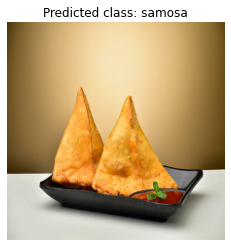

In [ ]:
predict_and_plot(pre_trained_model, class_names, 'samosa.jpeg', 224, False)

Predicted Probability: 0.3109999895095825


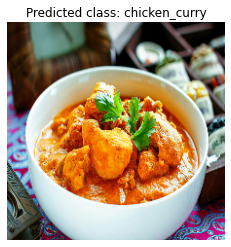

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-chicken_curry.jpeg', 224, False)

Predicted Probability: 0.9990000128746033


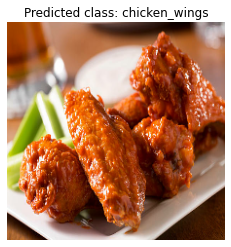

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-chicken_wings.jpeg', 224, False)

Predicted Probability: 0.7910000085830688


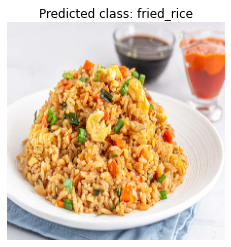

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-fried-rice.jpeg', 224, False)

Predicted Probability: 0.9760000109672546


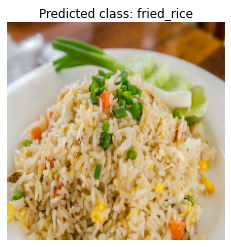

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-fried-rice2.jpeg', 224, False)

Predicted Probability: 0.9980000257492065


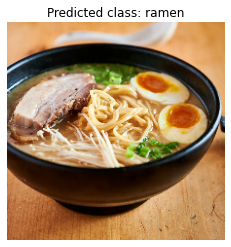

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-ramen.jpeg', 224, False)

Predicted Probability: 0.9909999966621399


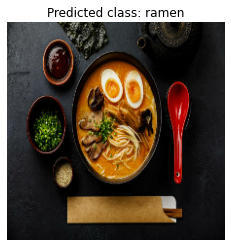

In [ ]:
predict_and_plot(pre_trained_model, class_names, '03-ramen2.jpeg', 224, False)

Predicted Probability: 0.39800000190734863


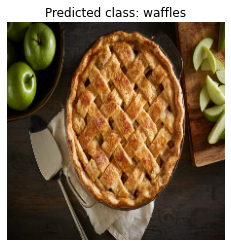

In [ ]:
predict_and_plot(pre_trained_model, class_names, '06-apple_pie.jpeg', 224, False)

Predicted Probability: 0.2930000126361847


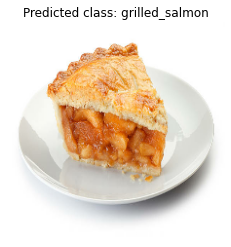

In [ ]:
predict_and_plot(pre_trained_model, class_names, '06-apple_pie2.jpeg', 224, False)

Predicted Probability: 0.5120000243186951


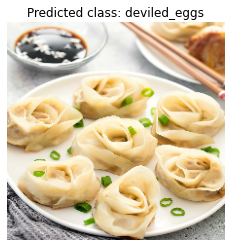

In [ ]:
predict_and_plot(pre_trained_model, class_names, '06-dumplings.jpeg', 224, False)

Predicted Probability: 0.9980000257492065


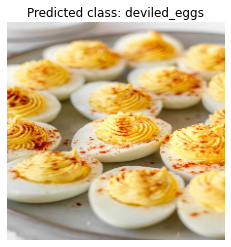

In [ ]:
predict_and_plot(pre_trained_model, class_names, '06-deviled_eggs.jpeg', 224, False)

### Find the most wrong predictions
We'll find the prediction that are wrong as well as the prediction probability is high. That means for those samples, the model is most confused. It can be due to
1. The label is incorrect
2. The classes are similar

In [39]:
import os
file_list = []

for class_name in class_names:
  class_path = test_dir + '/' + class_name + '/' 
  file_names = sorted(os.listdir(class_path))
  for file_name in file_names:
    file_list.append(class_path + file_name)
len(file_list)

25250

In [40]:
file_list[:10]

['101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 '101_food_classes_10_percent/test/apple_pie/101251.jpg',
 '101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 '101_food_classes_10_percent/test/apple_pie/103801.jpg',
 '101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 '101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 '101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 '101_food_classes_10_percent/test/apple_pie/110043.jpg',
 '101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 '101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [41]:
len(y_true), len(y_pred), len(preds), len(file_list)

(25250, 25250, 25250, 25250)

In [42]:
preds.shape

(25250, 101)

In [44]:
max_probs = tf.reduce_max(preds, axis=1).numpy()
len(max_probs), max_probs[:10]

(25250, array([0.84741855, 0.9640168 , 0.9592587 , 0.6586065 , 0.36790055,
        0.45675474, 0.61124235, 0.47313246, 0.24539654, 0.72438955],
       dtype=float32))

In [46]:
pred_classes = [class_names[y] for y in y_pred]
true_classes = [class_names[y] for y in y_true]

In [47]:
df_all_files_preds = pd.DataFrame({
    'file_name': file_list,
    'true_label': y_true,
    'predicted_label': y_pred,
    'true_class': true_classes,
    'predicted_class': pred_classes,
    'prediction_prob': max_probs
})

In [48]:
df_all_files_preds.head(10)

file_name  true_label  \
0  101_food_classes_10_percent/test/apple_pie/101...           0   
1  101_food_classes_10_percent/test/apple_pie/101...           0   
2  101_food_classes_10_percent/test/apple_pie/103...           0   
3  101_food_classes_10_percent/test/apple_pie/103...           0   
4  101_food_classes_10_percent/test/apple_pie/103...           0   
5  101_food_classes_10_percent/test/apple_pie/104...           0   
6  101_food_classes_10_percent/test/apple_pie/106...           0   
7  101_food_classes_10_percent/test/apple_pie/110...           0   
8  101_food_classes_10_percent/test/apple_pie/110...           0   
9  101_food_classes_10_percent/test/apple_pie/111...           0   

   predicted_label true_class        predicted_class  prediction_prob  
0               52  apple_pie                  gyoza         0.847419  
1                0  apple_pie              apple_pie         0.964017  
2                0  apple_pie              apple_pie         0.959259  
3               80  apple_pie   pulled_pork_sandwich         0.658607  
4               79  apple_pie              prime_rib         0.367901  
5               61  apple_pie  lobster_roll_sandwich         0.456755  
6               29  apple_pie              cup_cakes         0.611242  
7                0  apple_pie              apple_pie         0.473132  
8               85  apple_pie                 samosa         0.245397  
9                0  apple_pie              apple_pie         0.724390

In [50]:
wrong_predictions_df = df_all_files_preds[df_all_files_preds.true_label != df_all_files_preds.predicted_label].sort_values('prediction_prob', ascending=False)
wrong_predictions_df.head(10)

file_name  true_label  \
21810  101_food_classes_10_percent/test/scallops/1784...          87   
231    101_food_classes_10_percent/test/apple_pie/827...           0   
15359  101_food_classes_10_percent/test/lobster_roll_...          61   
23539  101_food_classes_10_percent/test/strawberry_sh...          94   
21400  101_food_classes_10_percent/test/samosa/314001...          85   
24540  101_food_classes_10_percent/test/tiramisu/1653...          98   
2511   101_food_classes_10_percent/test/bruschetta/12...          10   
5574   101_food_classes_10_percent/test/chocolate_mou...          22   
17855  101_food_classes_10_percent/test/paella/231446...          71   
23797  101_food_classes_10_percent/test/sushi/1659357...          95   

       predicted_label             true_class        predicted_class  \
21810               29               scallops              cup_cakes   
231                100              apple_pie                waffles   
15359               53  lobster_roll_sandwich              hamburger   
23539               83   strawberry_shortcake        red_velvet_cake   
21400               92                 samosa           spring_rolls   
24540               83               tiramisu        red_velvet_cake   
2511                61             bruschetta  lobster_roll_sandwich   
5574                21       chocolate_mousse         chocolate_cake   
17855               65                 paella                mussels   
23797               86                  sushi                sashimi   

       prediction_prob  
21810         0.999997  
231           0.999995  
15359         0.999988  
23539         0.999987  
21400         0.999981  
24540         0.999947  
2511          0.999945  
5574          0.999939  
17855         0.999931  
23797         0.999904

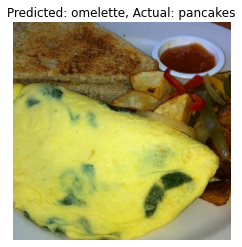

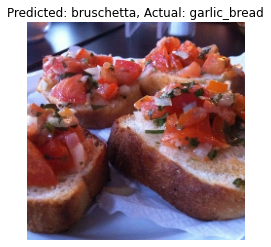

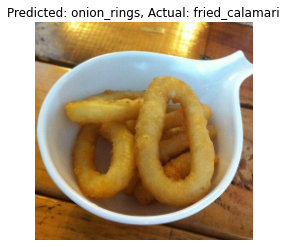

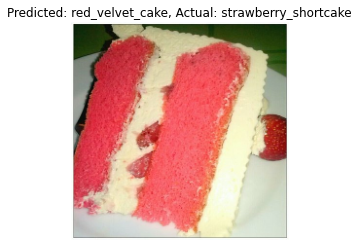

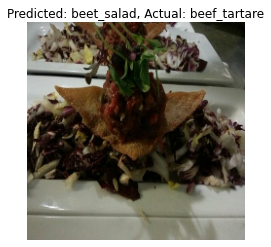

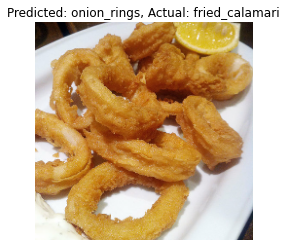

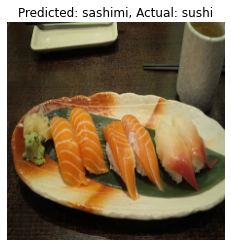

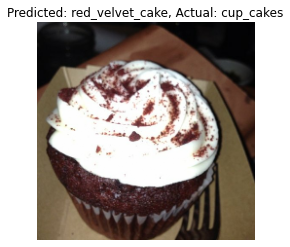

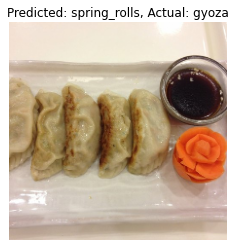

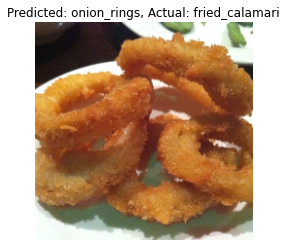

In [57]:
start_index = 10
for i in range(start_index, start_index+10):
  file_name = wrong_predictions_df.iloc[i]['file_name']
  true_class = wrong_predictions_df.iloc[i]['true_class']
  predict_and_plot(pre_trained_model, class_names, file_name, 224, False, true_class=true_class)

'101_food_classes_10_percent/test/scallops/1784196.jpg'